In [38]:

import ambientadorffnp_local2 as ffnp
import config
#Genero la carpeta temporal
import os 
from os import path

dirName = 'temp'

if path.exists("temp") == False:
 os.mkdir(dirName)

Cargo el lote

In [42]:
import geemap
#import geemap.eefolium as geemap
Map = geemap.Map(center=[-36,-63], zoom=4)
url = 'http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Map', attribution='Google')
Map.addLayerControl()


Map

Map(center=[-36, -63], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [5]:
import ipywidgets as widgets

uploader = widgets.FileUpload(button_style='primary',  accept='.kml',description="KML")
display(uploader)

FileUpload(value={}, accept='.geojson', button_style='primary', description='KML')

C:\Users\Usuario\miniconda3\envs\AmbientadorFFNP\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Archivo cargado


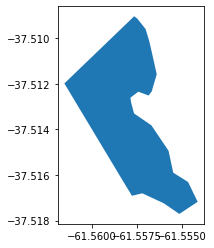

In [45]:
import config
import ee
import json
import tempfile
import geopandas as gpd
from ipywidgets import Checkbox, HBox, VBox
import ipywidgets as widgets


style = {'description_width': 'initial'}

output = widgets.Output()

subirkml = widgets.Button(
    description='Agregar Lote',
    button_style='primary',
    tooltip='Click para buscar imagenes',
    style=style
)



def subirkml_clicked(b):
    
 with output:
        print("Iniciando...")
 llaves = uploader.value.keys()
 
 if llaves.__len__() != 0:
    try:
        nombre_archivo = key

        contents = uploader.value[nombre_archivo]['content']
        contents.decode("utf-8") 

        f = open("temp/lote.kml", "w")
        f.write(contents.decode("utf-8"))
        f.close()

        geojson,df1,nombrelote = ffnp.ingresar_poligono(nombre_archivo,"temp/lote.kml")
        print("Archivo cargado")
        #Grafico
        d = json.loads(geojson)
        geometria = (d['features'][0]["geometry"]["coordinates"])
        lote = ee.Geometry.Polygon(geometria[0])
        Map.addLayer(lote,{}, "Lotes")
        Map.centerObject(lote, 14)
    
    except:
     with output:
         print("No se cargo un archivo valido, por favor revise el geojson o visite https://github.com/francofrolla/ ")
    
       
    
 if llaves.__len__() == 0:
  lote = ee.
  with output:
   print("No se selecciono ningun archivo")

 return lote
     
 
  

subirkml.on_click(subirkml_clicked)
HBox([subirkml,output])

In [ ]:
nombrelote= "pascual"

ruta=r"C:\Users\francofrolla\Google Drive\ambientaciones\datos de prueba\lote2.kml"
geojson,df1,nombrelote = ffnp.ingresar_poligono(nombrelote,ruta)

Genero composocion mensual de Sentinel 2, descargo datos y grafico

In [ ]:
import ee
ee.Initialize()

def busqueda_imagenes(geojson,año_inicio,año_fin,mes_inicio,mes_fin):
  #los valores pord defecto son 0.3,0.75 y 100
  
  import ee
  import json
  from pandas.io.json import json_normalize
  import pandas as pd
  import numpy as np
  import fiona
  import seaborn as sns
  import geopandas as gpd
  import matplotlib.pyplot as plt
  from IPython.display import HTML, display
  import time
  from pyproj import CRS

  
  d = json.loads(geojson)
  geometria = (d['features'][0]["geometry"]["coordinates"])
  lote = ee.Geometry.Polygon(geometria[0])

    
  loteentero = lote
  lote = lote.buffer(-35)

  coleccionfiltrada = ee.ImageCollection('COPERNICUS/S2').filterBounds(lote).filter(ee.Filter.calendarRange(año_inicio,año_fin,'year'))
  
  lista = coleccionfiltrada.toList(coleccionfiltrada.size())
  imagen = ee.Image(lista.get(0))
  lista = lista.add(imagen)

  def detectar_duplicador(imagen):
        esduplicado = ee.String("")
        numero = lista.indexOf(imagen)
        imagen1 = ee.Image(lista.get(numero.add(1)))
        #Compare the image(0) in the ImageCollection with the image(1) in the List
        fecha1 = imagen.date().format("Y-M-d")
        fecha2 = imagen1.date().format("Y-M-d")
        estado = ee.Algorithms.IsEqual(fecha1,fecha2)
        esduplicado = ee.String(ee.Algorithms.If(estado,"duplicado","no duplicado"));
        imagen = imagen.set("duplicado", esduplicado)
        return imagen

  coleccionfiltrada = coleccionfiltrada.map(lambda image: detectar_duplicador(image))
  coleccionfiltrada = coleccionfiltrada.filter(ee.Filter.eq('duplicado', "no duplicado"))

  print("Filtrado de imagenes con la misma fecha")



  coleccionfiltrada = coleccionfiltrada.map(lambda img: img.clip(loteentero))

  def agregar_nubes(image): 
      meanDict = image.reduceRegion(
      reducer= ee.Reducer.anyNonZero(),
      geometry= lote,
      scale= 10,
      )
      image = image.set("mascara",meanDict.get("QA60"))
      return image

  coleccionfiltrada = coleccionfiltrada.map(lambda image: agregar_nubes(image));
  coleccionfiltrada = coleccionfiltrada.filterMetadata('mascara', 'equals', 0);
  print("Pasando por filtro de nubes")
  

  def ndvi(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    img = img.addBands(ndvi)
    return img

  coleccionfiltrada = coleccionfiltrada.map(lambda img: ndvi(img))
    
    
  #Genero un mosaico mensual
  #Mosaico mensual para NDVI. 
  # Modificado de https://gis.stackexchange.com/questions/258344/reduce-image-collection-to-get-annual-monthly-sum-precipitation
  #Se modificca para coincidir con los meses
 
    

  def sacar_meses(imagen):
    fecha = imagen.date().format("MM")
    imagen = imagen.set("meses",fecha)
    return imagen
   
  coleccion2017 = coleccionfiltrada.filter(ee.Filter.calendarRange(2017, 2017, 'year'))
  coleccion2018 = coleccionfiltrada.filter(ee.Filter.calendarRange(2018, 2018, 'year'))
  coleccion2019 = coleccionfiltrada.filter(ee.Filter.calendarRange(2019, 2019, 'year'))
  coleccion2020 = coleccionfiltrada.filter(ee.Filter.calendarRange(2020, 2020, 'year'))

  coleccion2017 = coleccion2017.map(lambda imagen:sacar_meses(imagen))
  coleccion2018 = coleccion2018.map(lambda imagen:sacar_meses(imagen))
  coleccion2019 = coleccion2019.map(lambda imagen:sacar_meses(imagen))
  coleccion2020 = coleccion2020.map(lambda imagen:sacar_meses(imagen))

  meses2017 = coleccion2017.aggregate_array("meses").distinct()   
  meses2018 = coleccion2018.aggregate_array("meses").distinct()   
  meses2019 = coleccion2019.aggregate_array("meses").distinct()   
  meses2020 = coleccion2020.aggregate_array("meses").distinct()   
    
  def convertir_string(valor):
    return ee.Number.parse(valor)

  meses2017 = meses2017.map(lambda valor:convertir_string(valor))
  meses2018 = meses2018.map(lambda valor:convertir_string(valor))
  meses2019 = meses2019.map(lambda valor:convertir_string(valor))
  meses2020 = meses2020.map(lambda valor:convertir_string(valor))

    
    
    

  def mosaico_mensual_2017(m):
      coleccion = coleccion2017.filter(ee.Filter.calendarRange(m, m, 'month')).select(['NDVI','B4', 'B3', 'B2'])
      fecha = coleccion.first().date().format("YYYY-MM")
      año = coleccion.first().date().format("YYYY")
      imagen = coleccion.mean()
      imagen = imagen.set('month', m)  
      #fecha = imagen.select("NDVI").date().format("YYYY-MM")
      imagen = imagen.set("system:time_start", fecha) 
      imagen = imagen.set("year", año) 
      return imagen
    
  def mosaico_mensual_2018(m):
      coleccion = coleccion2018.filter(ee.Filter.calendarRange(m, m, 'month')).select(['NDVI','B4', 'B3', 'B2'])
      fecha = coleccion.first().date().format("YYYY-MM")
      año = coleccion.first().date().format("YYYY")
      imagen = coleccion.mean()
      imagen = imagen.set('month', m)  
      #fecha = imagen.select("NDVI").date().format("YYYY-MM")
      imagen = imagen.set("system:time_start", fecha) 
      imagen = imagen.set("year", año) 
      return imagen

  def mosaico_mensual_2019(m):
      coleccion = coleccion2019.filter(ee.Filter.calendarRange(m, m, 'month')).select(['NDVI','B4', 'B3', 'B2'])
      fecha = coleccion.first().date().format("YYYY-MM")
      año = coleccion.first().date().format("YYYY")
      imagen = coleccion.mean()
      imagen = imagen.set('month', m)  
      #fecha = imagen.select("NDVI").date().format("YYYY-MM")
      imagen = imagen.set("system:time_start", fecha) 
      imagen = imagen.set("year", año) 
      return imagen
    
  def mosaico_mensual_2020(m):
      coleccion = coleccion2020.filter(ee.Filter.calendarRange(m, m, 'month')).select(['NDVI','B4', 'B3', 'B2'])
      fecha = coleccion.first().date().format("YYYY-MM")
      año = coleccion.first().date().format("YYYY")
      imagen = coleccion.mean()
      imagen = imagen.set('month', m)  
      #fecha = imagen.select("NDVI").date().format("YYYY-MM")
      imagen = imagen.set("system:time_start", fecha) 
      imagen = imagen.set("year", año) 
      return imagen

  
  coleccionfiltrada2017 = ee.ImageCollection.fromImages(meses2017.map(lambda m: mosaico_mensual_2017(m)))
  coleccionfiltrada2018 = ee.ImageCollection.fromImages(meses2018.map(lambda m: mosaico_mensual_2018(m)))
  coleccionfiltrada2019 = ee.ImageCollection.fromImages(meses2019.map(lambda m: mosaico_mensual_2019(m)))
  coleccionfiltrada2020 = ee.ImageCollection.fromImages(meses2020.map(lambda m: mosaico_mensual_2020(m)))
                                                     
  coleccionfiltrada = coleccionfiltrada2017.merge(coleccionfiltrada2018)         
  coleccionfiltrada = coleccionfiltrada.merge(coleccionfiltrada2019)
  coleccionfiltrada = coleccionfiltrada.merge(coleccionfiltrada2020)
  

  def ndvi_medio(image):
      image1 = image.select("NDVI").rename("NDVI_medio")
      reduced = image1.reduceRegion(geometry=lote, reducer=ee.Reducer.mean(), scale=10)
      image = image.set(reduced)
      return image
  def ndvi_sd(image):
      image1 = image.select("NDVI").rename("NDVI_sd")
      reduced = image1.reduceRegion(geometry=lote, reducer=ee.Reducer.stdDev(), scale=10)
      image = image.set(reduced)
      return image
  def normalidad(image):
      image1 = image.select("NDVI").rename("normalidad")
      reduced = ee.Number(ee.Number(image1.get("NDVI_medio")).divide(ee.Number(image1.get("NDVI_mediana"))))
      image = image.set("normalidad",reduced)
      return image
  def ndvi_cv(image):
      sd = ee.Number(image.get("NDVI_sd"))
      medio = ee.Number(image.get("NDVI_medio"))
      cv = sd.divide(medio).multiply(100)
      image = image.set("cv",cv)
      return image
  

  coleccionfiltrada = coleccionfiltrada.map(lambda imagen: ndvi_medio(imagen))
  coleccionfiltrada = coleccionfiltrada.map(lambda imagen: ndvi_sd(imagen))
  coleccionfiltrada = coleccionfiltrada.map(lambda imagen: ndvi_cv(imagen))
  
  print("Armando diccionario y descargando datos del servidor")

  fechas = coleccionfiltrada.aggregate_array("system:time_start")
  años = coleccionfiltrada.aggregate_array("year")

  NDVI_medio = coleccionfiltrada.aggregate_array("NDVI_medio")
  NDVI_sd = coleccionfiltrada.aggregate_array("NDVI_sd")
  meses = coleccionfiltrada.aggregate_array("month")
    
  test_dict = ee.Dictionary.fromLists(['system:time_start', 'NDVI_medio','NDVI_sd','años','mes'], [fechas, NDVI_medio,NDVI_sd,años,meses])
  featureCollection = ee.FeatureCollection([ee.Feature(None, test_dict)])
  
    
 
    
    
  link = featureCollection.getDownloadURL(filetype="CSV", selectors=None, filename=None)
  #Generamos el diccionario con los valores.
  import csv, urllib.request
  response = urllib.request.urlopen(link)
  lines = [l.decode('utf-8') for l in response.readlines()]
  reader = csv.DictReader(lines)

  print("Covirtiendo a dataframe")

  data = list(reader)
  # Converting string to list
  fechas_cliente = data[0]["system:time_start"].strip('][').split(', ')
  ndvi_cliente = data[0]["NDVI_medio"].strip('][').split(', ')
  sd_ndvi_cliente = data[0]["NDVI_sd"].strip('][').split(', ')
  años_cliente = data[0]["años"].strip('][').split(', ')
  meses_cliente = data[0]["mes"].strip('][').split(', ')
  
  fechas_cliente = map(str, fechas_cliente)
  fechas = list(fechas_cliente)
  
  ndvi_cliente = map(float, ndvi_cliente)
  sd_ndvi_cliente = map(float, sd_ndvi_cliente)
  años_cliente = map(float, años_cliente)
  meses_cliente = map(float, meses_cliente)

  #Genero dataframe con los datos
  df = pd.DataFrame(list(zip(fechas, ndvi_cliente,sd_ndvi_cliente,años_cliente,meses_cliente)),columns =['Fecha', 'NDVI_medio',"sd_ndvi","años","meses"])
  print("Exito!")
  return df, coleccionfiltrada,loteentero

datos_lote,coleccion,lote = busqueda_imagenes(geojson,2017,2020,1,12)

In [ ]:

#Graficamos lo que vemos

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

#Si algun mes no tiene datos lo reemplazo or NULL
for a in range(2017,2021):
 datos = datos_lote[datos_lote['años'] == a]
 for i in range(1,12):
  condicion = i in list(datos["meses"])
  if condicion is False:
   fecha =  (str(a)+"-"+str(i))
   df = pd.DataFrame([[fecha, None,None,a,i]],columns =['Fecha', 'NDVI_medio',"sd_ndvi","años","meses"])
   datos_lote = datos_lote.append(df)


datos2017 = datos_lote[datos_lote['años'] == 2017].sort_values(by=['meses'])
datos2018 = datos_lote[datos_lote['años'] == 2018].sort_values(by=['meses'])
datos2019 = datos_lote[datos_lote['años'] == 2019].sort_values(by=['meses'])
datos2020 = datos_lote[datos_lote['años'] == 2020].sort_values(by=['meses'])
fechas= pd.Series([1,2,3,4,5,6,7,8,9,10,11,12])


                            
                             
                             
#fig, axs = plt.subplots(2,1)
fig, ax = plt.subplots(1,1,figsize=(15,10))

#2017
transparencia=0.4
colorlinea = '#CC4F1B'
edgecolor= '#CC4F1B'
facecolor= '#CC4F1B'
ndvi =  datos2017["NDVI_medio"]
sdmas =  datos2017["NDVI_medio"]+datos2017["sd_ndvi"]
sdmenos =  datos2017["NDVI_medio"]-datos2017["sd_ndvi"]

ax.plot(fechas, ndvi,'k-',color=colorlinea,label=2017)
ax.fill_between(fechas,sdmenos,sdmas, alpha=transparencia, edgecolor=edgecolor, facecolor=facecolor,
    linewidth=4, antialiased=True)

#2018
transparencia=0.4
colorlinea = '#1B2ACC'
edgecolor= '#1B2ACC'
facecolor= '#1B2ACC'
ndvi =  datos2018["NDVI_medio"]
sdmas =  datos2018["NDVI_medio"]+datos2018["sd_ndvi"]
sdmenos =  datos2018["NDVI_medio"]-datos2018["sd_ndvi"]

ax.plot(fechas, ndvi,'k-',color=colorlinea,label=2018)
ax.fill_between(fechas,sdmenos,sdmas, alpha=transparencia, edgecolor=edgecolor, facecolor=facecolor,
    linewidth=4, antialiased=True)

#2019
transparencia=0.4
colorlinea = '#3F7F4C'
edgecolor= '#3F7F4C'
facecolor= '#3F7F4C'
ndvi =  datos2019["NDVI_medio"]
sdmas =  datos2019["NDVI_medio"]+datos2019["sd_ndvi"]
sdmenos =  datos2019["NDVI_medio"]-datos2019["sd_ndvi"]

ax.plot(fechas, ndvi,'k-',color=colorlinea,label=2019)
ax.fill_between(fechas,sdmenos,sdmas, alpha=transparencia, edgecolor=edgecolor, facecolor=facecolor,
    linewidth=4, antialiased=True)

#2020
transparencia=0.4
colorlinea = '#F6FF33'
edgecolor= '#F6FF33'
facecolor= '#F6FF33'
ndvi =  datos2020["NDVI_medio"]
sdmas =  datos2020["NDVI_medio"]+datos2020["sd_ndvi"]
sdmenos =  datos2020["NDVI_medio"]-datos2020["sd_ndvi"]

ax.plot(fechas, ndvi,'k-',color=colorlinea,label=2020)
ax.fill_between(fechas,sdmenos,sdmas, alpha=transparencia, edgecolor=edgecolor, facecolor=facecolor,
    linewidth=4, antialiased=True)

ax.set_title('Evolucion de NDVI en KML cargado')
#ax.set(xlabel="MES",ylabel="NDVI",fontsize=18)
ax.set_ylabel('NDVI', fontsize = 20.0) # Y label
ax.set_xlabel('MES', fontsize = 20) # X label
ax.legend(prop=dict(size=18))

ax.tick_params(labelsize=15)


#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#fig.show()


In [ ]:
from ipywidgets import Checkbox, HBox, VBox
from IPython.display import display, clear_output
import ipyleaflet
import ipywidgets as widgets


#CONSTANTES DEL MAPA
#palette = ['#FFFFFF', '#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901', '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01', '#012E01', '#011D01', '#011301']
#Map.add_colorbar_branca(colors=palette,vmin=0.2,vmax=0.7)
output_widget = widgets.Output(layout={'border': '1px solid black',"font_weight": "5px"})
output_control = ipyleaflet.WidgetControl(widget=output_widget, position='bottomleft')
Map.add_control(output_control)

#selfechas = widgets.Dropdown(
#    options=config.listaid,
#    value=config.listaid[0],
#    description='Seleccione Fecha:',
#    disabled=False,
#)
years = [2017,2018,2019,2020]
mes = [1,2,3,4,5,6,7,8,9,10,11,12]

selyear = widgets.Dropdown(
    options=years,
    value=years[0],
    description='Año:',
    disabled=False,
)

selmes = widgets.Dropdown(
    options=mes,
    value=mes[0],
    description='Mes:',
    disabled=False,
)


boton1 = widgets.Button(description='Graficar NDVI',button_style='primary')
boton2 = widgets.Button(description='Graficar',button_style='primary')

out1 = widgets.Output()


def graficar_onclicked(b):
 coleccion1 = coleccion.filterMetadata('year', 'equals', str(selyear.value))
 coleccion1 = coleccion1.filterMetadata('month', 'equals', selmes.value)
 escena = ee.Image(coleccion1.first())

 params = escena.reduceRegion(
           reducer= ee.Reducer.percentile([10, 90]), 
           geometry= lote, 
           scale= 10,
           )

 parametros = params.getInfo()
 min_valor = [parametros['NDVI_p10']]
 max_valor = [parametros['NDVI_p90']]

 vis_params = {
              'min': min_valor,
              'max': max_valor,
              'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']}
 
 fecha = str(selyear.value)+" "+str(selmes.value)
 with out1:
  texto = "Graficando imagen "+fecha+" NDVI min:"+ str(min_valor) +" NDVI max:"+ str(max_valor) 
  print(texto)

 Map.addLayer(escena, vis_params, fecha)

 with output_widget:
  clear_output()
  print(texto)

def graficar_cv_onclicked(b):
 #Borro lo anterior
 coleccion1 = coleccion.filterMetadata('year', 'equals', str(selyear.value))
 coleccion1 = coleccion1.filterMetadata('month', 'equals', selmes.value)
 escena = ee.Image(coleccion1.first())
 
 
 fecha = str(selyear.value)+" "+str(selmes.value)

 params = escena.select(["B4","B3","B2"]).reduceRegion(
      reducer= ee.Reducer.percentile([5, 95]), 
      geometry= lote, 
      scale= 10,
      )
 parametros = params.getInfo()
 min_escena = [parametros['B4_p5'], parametros['B3_p5'], parametros['B2_p5']]
 max_escena = [parametros['B4_p95'], parametros['B3_p95'], parametros['B2_p95']]

 vis_params = {
              'bands':['B4', 'B3', 'B2'],
              'min': min_escena,
              'max': max_escena,
               }

 with out1:
  texto = "Graficando imagen "+fecha 
  print(fecha)

 Map.addLayer(escena, vis_params, fecha)

 with output_widget:
  clear_output()
  print("Graficando" + texto)
  

boton1.on_click(graficar_onclicked)
boton2.on_click(graficar_cv_onclicked)

botones = HBox([selyear,selmes,boton1,boton2])
VBox([botones,out1])

In [ ]:
%%time   
def graficar_folium(lote,año,mes):  
    import folium
    import branca.colormap as cm
    palette = ['#FFFFFF', '#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901', '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01', '#012E01', '#011D01', '#011301']
 
    limites = lote.centroid()
    centro = limites.getInfo()
    centro = centro['coordinates']
    centro_array = [centro[1],centro[0]]

    # Define a method for displaying Earth Engine image tiles to folium map.
    def add_ee_layer(self, ee_image_object, vis_params, name):
     map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
     folium.raster_layers.TileLayer(
     tiles = map_id_dict['tile_fetcher'].url_format,
     #tiles = "Stamen Terrain",
     attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
     name = name,
     overlay = True,
     control = True
     ).add_to(self)

    # Add EE drawing method to folium.
    folium.Map.add_ee_layer = add_ee_layer


    # Create a folium map object.


    my_map = folium.Map(location=centro_array, zoom_start=14,width='60%',height='60%')

    coleccion1 = coleccion.filterMetadata('year', 'equals', str(selyear.value))
    coleccion1 = coleccion1.filterMetadata('month', 'equals', selmes.value)
    escena = ee.Image(coleccion1.first())

    params = escena.reduceRegion(
          reducer= ee.Reducer.percentile([10, 90]), 
          geometry= lote, 
          scale= 10,
          )

    parametros = params.getInfo()
    min_valor = [parametros['NDVI_p10']]
    max_valor = [parametros['NDVI_p90']]

    vis_params = {
      'min': min_valor,
      'max': max_valor,
      'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']}
     
    colormap = cm.LinearColormap(colors=palette,vmin=min_valor[0],vmax=max_valor[0])
    colormap.add_to(my_map)

    my_map.add_ee_layer(escena, vis_params, "NDVI")
    my_map.add_child(folium.LayerControl())

    display(my_map)
    return

graficar_folium(lote,2017,6)

In [ ]:
%%time

#Descargar imagenes via link

años=[2018]
meses=[2,3,4,5]

def funcion_sentinel(coleccion,años,meses):
    laimagen = ee.Image()
    for i in meses:
     coleccion1 = coleccion.filterMetadata('year', 'equals', años)
     coleccion1 = coleccion1.filterMetadata('month', 'equals', i)
     imagen = ee.Image(coleccion1.first()).rename(str(i))
     laimagen = laimagen.addBands(imagen)
    
    nombre = str(años)
    print(nombre)
    print("Descargando...")
    path = laimagen.getDownloadUrl({
      'name': nombre,
      'scale' : 10,
      'region' : lote})
    print(path)
    return laimagen, nombre



#Año tiene que estar en formato string
#Meses en int

Recorte, nombre = funcion_sentinel(coleccion,str(años[0]),meses)

Termina el script... abajo hay ideas

In [ ]:
#Descargar imagenes via drive asincronico

downConfig = {'scale': 10, "maxPixels": 1.0E13, 'driveFolder': 'ambientaciones_crea'}  # scale means resolution.



años=[2020]
meses=[7,8,9,10,11]

def funcion_sentinel(coleccion,años,meses):
    coleccion1 = coleccion.filterMetadata('year', 'equals', años)
    coleccion1 = coleccion1.filterMetadata('month', 'equals', meses)
    imagen = ee.Image(coleccion1.first())
    nombre = str(años)+"-"+str(meses)
    print(nombre)
    return imagen, nombre

#Año tiene que estar en formato string
#Meses en int

for i in meses:
  Recorte, nombre = funcion_sentinel(coleccion,str(años[0]),i)
  downConfig = {
    'fileNamePrefix': nombre,
    'scale': 10,
    'fileFormat': 'GeoTIFF',
    'region': lote,
    'folder': 'ambientaciones_crea'
    }
  task = ee.batch.Export.image.toDrive(Recorte,nombre, **downConfig)
  task.start()


In [ ]:
#Descargar imagenes via link



años=[2020]
meses=[7,8,9,10,11]

def funcion_sentinel(coleccion,años,meses):
    coleccion1 = coleccion.filterMetadata('year', 'equals', años)
    coleccion1 = coleccion1.filterMetadata('month', 'equals', meses)
    imagen = ee.Image(coleccion1.first())
    nombre = str(años)+"-"+str(meses)
    print(nombre)
    print("Descargando...")
    path = imagen.getDownloadUrl({
      'name': nombre,
      'scale' : 10,
      'region' : lote})
    print(path)
    return imagen, nombre

#Año tiene que estar en formato string
#Meses en int

for i in meses:
  Recorte, nombre = funcion_sentinel(coleccion,str(años[0]),i)
  
